In [47]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.exceptions import NotFittedError

In [48]:
df = pd.read_csv("Customer_Data.csv")

In [49]:
dropped_columns = ['Customer_ID', 'Churn_Category', 'Churn_Reason', 'Unlimited_Data']
df = df.drop(dropped_columns, axis=1)

In [50]:
encoded_columns = ['Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 
                   'Online_Security', 'Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 
                   'Streaming_Music', 'Contract', 'Paperless_Billing', 'Payment_Method']

In [51]:
label_encoders = {}

In [52]:

for column in encoded_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [53]:
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [54]:
df['Customer_Status'] = df['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

In [55]:
df = df.dropna()

In [56]:
X = df.drop(columns=['Customer_Status'])
y = df['Customer_Status']

In [57]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [59]:
scaler = StandardScaler()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

In [60]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('rf_model', rf_model)
])

In [61]:
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88      1277
         1.0       0.89      0.88      0.88      1288

    accuracy                           0.88      2565
   macro avg       0.88      0.88      0.88      2565
weighted avg       0.88      0.88      0.88      2565



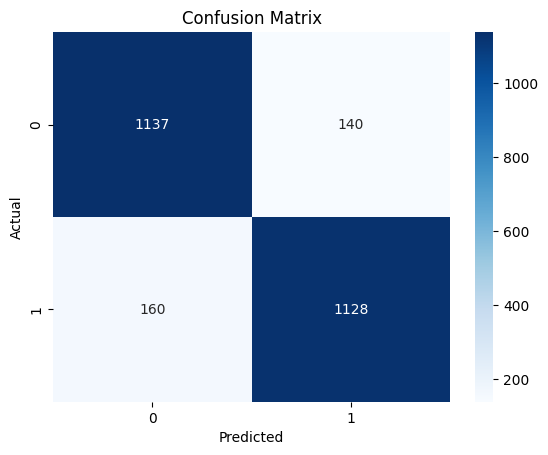

In [62]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
display = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

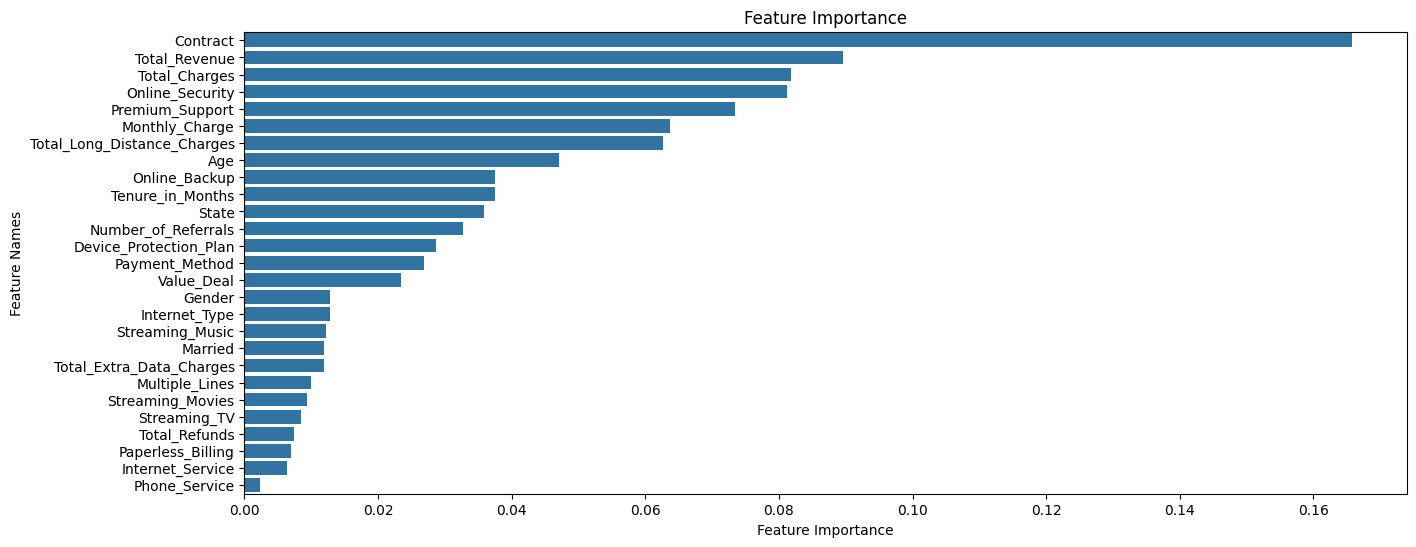

In [63]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15,6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance")
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.show()

In [64]:
joblib.dump(pipeline, 'churn_prediction_model.pkl')

['churn_prediction_model.pkl']

In [65]:
'''new_df = pd.read_csv("Customer_Data.csv")
original_data = new_df.copy()
customer_ids = new_df['Customer_ID']
new_df = new_df.drop(dropped_columns, axis=1)
'''

'new_df = pd.read_csv("Customer_Data.csv")\noriginal_data = new_df.copy()\ncustomer_ids = new_df[\'Customer_ID\']\nnew_df = new_df.drop(dropped_columns, axis=1)\n'

In [66]:
'''for column in new_df.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        new_df[column] = new_df[column].map(lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1)
    else:
        print(f"Skipping {column}, as it was not in training")
'''

'for column in new_df.select_dtypes(include=[\'object\']).columns:\n    if column in label_encoders:\n        new_df[column] = new_df[column].map(lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1)\n    else:\n        print(f"Skipping {column}, as it was not in training")\n'

In [67]:
label_encoders = joblib.load('label_encoders.pkl')

In [68]:
'''new_df = new_df[X_train.columns]'''

'new_df = new_df[X_train.columns]'

In [69]:
'''new_predictions = pipeline.predict(new_df)
original_data['Predictions'] = new_predictions
original_data = original_data[original_data['Predictions'] == 1]
original_data.to_csv("predictions.csv", index=False)
'''

'new_predictions = pipeline.predict(new_df)\noriginal_data[\'Predictions\'] = new_predictions\noriginal_data = original_data[original_data[\'Predictions\'] == 1]\noriginal_data.to_csv("predictions.csv", index=False)\n'

In [70]:
label_encoders = joblib.load('label_encoders.pkl')

In [71]:
new_df = pd.read_csv("Customer_Data.csv")
original_data = new_df.copy()

new_df = new_df.drop(dropped_columns, axis=1)

for column in new_df.select_dtypes(include=['object']).columns:
    if column in label_encoders:
        new_df[column] = new_df[column].map(
            lambda x: label_encoders[column].transform([x])[0] if x in label_encoders[column].classes_ else -1
        )
    else:
        print(f"Skipping {column}, as it was not in training")

new_df = new_df[X_train.columns]

if new_df.shape[1] == X_train.shape[1]:  
    churn_probs = pipeline.predict_proba(new_df)[:, 1]  
    original_data['Churn_Probability'] = churn_probs
else:
    print("Feature mismatch! Check preprocessing steps.")



Skipping Customer_Status, as it was not in training


In [72]:

HIGH_RISK_THRESHOLD = 0.75 
MEDIUM_RISK_THRESHOLD = 0.50  


def classify_risk(prob):
    if prob >= HIGH_RISK_THRESHOLD:
        return "High Risk - Immediate Action Needed"
    elif prob >= MEDIUM_RISK_THRESHOLD:
        return "Medium Risk - Offer Incentives"
    else:
        return "Low Risk - Maintain Engagement"

original_data['Churn_Risk'] = original_data['Churn_Probability'].apply(classify_risk)

high_risk_customers = original_data[original_data['Churn_Risk'] == "High Risk - Immediate Action Needed"]
high_risk_customers.to_csv("high_risk_customers.csv", index=False)

def generate_recommendation(row):
    if row['Churn_Risk'] == "High Risk - Immediate Action Needed":
        return "Offer Discount & Call Support Team"
    elif row['Churn_Risk'] == "Medium Risk - Offer Incentives":
        return "Offer Loyalty Rewards"
    else:
        return "Send Thank You Email"

original_data['Recommendation'] = original_data.apply(generate_recommendation, axis=1)


original_data.to_csv("customer_recommendations.csv", index=False)


print("\n🚀 **High-Risk Customers Identified & Saved in 'high_risk_customers.csv'**")
print("✅ Personalized Recommendations Generated & Saved in 'customer_recommendations.csv'")


🚀 **High-Risk Customers Identified & Saved in 'high_risk_customers.csv'**
✅ Personalized Recommendations Generated & Saved in 'customer_recommendations.csv'
